In [2]:
import climakitae as ck
from climakitae.core.data_interface import get_data
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
import geopandas as gpd
import rioxarray as rxr
try:
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature
except ImportError:
    print("Cartopy still not working, try pip install cartopy")
    ccrs = None

# Configuration
warnings.filterwarnings("ignore", category=FutureWarning)
# Set higher DPI for better resolution suitable for publication
plt.rcParams['figure.dpi'] = 150 
STANDARD_CRS = "EPSG:4326" # WGS84
print("Setup complete.")

Setup complete.


In [3]:
#This cell was just to look at resolutions avaliable
from climakitae.core.data_interface import get_data_options
#My testing vars
cariablesToCheck = ["Air Temperature at 2m", "Precipitation (total)"]
# Iterate through the variables of interest
for car in cariablesToCheck:
    print(f"\nVariable: {car}")
    # Get the options dataframe for the specific variable
    try:
        options_df = get_data_options(variable=car)
        #Group by downscaling method to see the resolutions available for each
        grouped_options = options_df.groupby('downscaling_method')['resolution'].unique()
        if grouped_options.empty:
            print("bug no rezzy in df selection in line above")
        else:
            for method,resolutions in grouped_options.items():
                print(f" Method: {method}")
                # Convert the numpy array to a list for cleaner printing
                print(f"\t" "Resolutions: {list(resolutions)}")
                
    except Exception as e:
        print(f"problem with options for {car}. err as seen by: {e}")




Variable: Air Temperature at 2m
 Method: Dynamical
	Resolutions: {list(resolutions)}

Variable: Precipitation (total)
 Method: Dynamical
	Resolutions: {list(resolutions)}
 Method: Statistical
	Resolutions: {list(resolutions)}


In [ ]:
#lmfao, fix this and put it in depth one one folder
shapefile_path ="../JoshuaTreeOutlines/JoshuaTree/Joshua_Tree_National_Park.shp"
try:
    jTreeBoundary = gpd.read_file(shapefile_path)
    #boundary in standard CRS
    if jTreeBoundary.crs !=STANDARD_CRS:
        print(f"Reprojecting boundary from {jTreeBoundary.crs} to {STANDARD_CRS}...")
        jTreeBoundary =jTreeBoundary.to_crs(STANDARD_CRS)
    
    #need bounding box in: (minx, miny, maxx, maxy)
    bounds =jTreeBoundary.total_bounds
    longitude_slice = (bounds[0],bounds[2])
    latitude_slice = (bounds[1],bounds[3])
    print(f"bounds:Lat {latitude_slice}, Longi {longitude_slice}")

except Exception as e:
    print(f"err w/ loading shapefile @ {shapefile_path}: {e}")
    jTreeBoundary = None
    #fake bounds from prev weeks
    longitude_slice = (-116.6, -115.4)
    latitude_slice = (33.5, 34.3)

#params
VARIABLES = {
    "temp": "Air Temperature at 2m",
    "precip": "Precipitation (total)"
}
#high emission scenario. 
SCENARIOS = ["Historical Climate", "SSP 3-7.0"]
RESOLUTION = "3 km"
#here are the 30 window periods that we were talking about in lab meeting, but double
#check that these are right
BASELINE_PERIOD = {"name": "Baseline (1985-2014)", "years": (1985, 2014)}
FUTURE_PERIOD = {"name": "Late-Century (2070-2099)", "years": (2070, 2099)}
TIME_SPAN = (BASELINE_PERIOD["years"][0], FUTURE_PERIOD["years"][1])

Reprojecting boundary from EPSG:4269 to EPSG:4326...
bounds:Lat (np.float64(33.67018975804256), np.float64(34.129346624363556)), Longi (np.float64(-116.4580411520462), np.float64(-115.26220149792678))


In [5]:
data_dict = {}
#Get data by month!
for key,varName in VARIABLES.items():
    try:
        print(f"Retrieving {key}...")
        data =get_data(
            variable=varName,resolution=RESOLUTION,   timescale="monthly", scenario=SCENARIOS,
            time_slice=TIME_SPAN,latitude=latitude_slice, longitude=longitude_slice )
        data_dict[key] = data
    except Exception as e:
        print(f"Error retrieving {key}: {e}")

#preprocesses
if 'temp' in data_dict and data_dict['temp'] is not None:
    #temperature in celcius for for Lucia & Maya and I suppose the majority of the entire world
    if data_dict['temp'].attrs.get('units') =='K':
        data_dict['temp'] = data_dict['temp']-273.15
        data_dict['temp'].attrs['units'] ='°C'

Retrieving temp...
Retrieving precip...


In [6]:
#This cell is just to inspect the data, needed this for debugging, but also helpful for anyone else to look at. 

for key, data in data_dict.items():
    if data is None:
        continue
    print(f"\nVarable: {key}")
    #Dimens and sizes
    print("  Dimensions:")
    for dim, size in data.sizes.items():
        print(f"    - {dim}: {size}")
        
    #CRS Information via rioxarray)
    print("  CRS Information:")
    dataCrs =data.rio.crs
    if dataCrs:
        # a concise representation
        print(f"  - CRS: {dataCrs.to_string()[:150]}...") 
    else:
        print("    - CRS: Not Found")
    #potential dimen mismatches
    print("  Auxiliary Coordinate Shapes Check:")
    aux_coords = ['lat','lon', 'landmask',
                  'lakemask']
    #get shape of main data var
    data_shape = (data.sizes.get('y', 'N/A'), data.sizes.get('x', 'N/A'))
    print(f"    Main Data Shape (y, x): {data_shape}")
    
    mismatchdDetected =False
    for coord in aux_coords:
        if coord in data.coords:
            coord_shape = (data[coord].sizes.get('y', 'N/A'), data[coord].sizes.get('x', 'N/A'))
            print(f"    -Coordinate '{coord}' Shape in (y, x)form is: {coord_shape}")
            if coord_shape != data_shape:
                print(f"      Warning: shape mismatch for '{coord}'. Must be dropped before reprojection happens.")
                mismatchdDetected = True
    
    if not mismatchdDetected:
        print(" No shape mismatches for aux coords")



Varable: temp
  Dimensions:
    - scenario: 1
    - simulation: 8
    - time: 1380
    - y: 33
    - x: 39
  CRS Information:
  - CRS: PROJCS["undefined",GEOGCS["undefined",DATUM["undefined",SPHEROID["undefined",6370000,0]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",...
  Auxiliary Coordinate Shapes Check:
    Main Data Shape (y, x): (33, 39)
    -Coordinate 'lat' Shape in (y, x)form is: (33, 39)
    -Coordinate 'lon' Shape in (y, x)form is: (33, 39)
    -Coordinate 'landmask' Shape in (y, x)form is: (33, 39)
    -Coordinate 'lakemask' Shape in (y, x)form is: (33, 39)
 No shape mismatches for aux coords

Varable: precip
  Dimensions:
    - scenario: 1
    - simulation: 8
    - time: 1380
    - y: 33
    - x: 39
  CRS Information:
  - CRS: PROJCS["undefined",GEOGCS["undefined",DATUM["undefined",SPHEROID["undefined",6370000,0]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",...
  Auxiliary Coordinate Shapes Check:
    Main Data Shape (y, x): (33, 39)
    

In [7]:
#Gets climatology for one of the priorly defined periods,
#and handles scenario sleection and aggregation too
def calculate_period_climatology(dataArray, startyear, endYear, varType):
    periodData = dataArray.sel(time=slice(str(startyear), str(endYear)))
    
    #np.atleast_1d paired wtih toNumpy() was helpful here as it seems to handle scalar coords w/o getting mad
    current_scenarios = list(np.atleast_1d(periodData.scenario.to_numpy()))
    if startyear <2015:
        #baseline period, choose scenario and drop the scenario demin
        if "Historical Climate" in current_scenarios:
             scenario_to_select ="Historical Climate"
        elif len(current_scenarios) >0:
             #fall back if historical climate is missing (i think in merged datasets this can occur)
             scenario_to_select = current_scenarios[0]
        else:
            return None, None
        if 'scenario' in periodData.dims:
            periodData = periodData.sel(scenario=scenario_to_select, drop=True)
        else:
             periodData = periodData.drop_vars('scenario', errors='ignore')
    else:
        #future period: ensure the scenario dimen exists
        if 'scenario' not in periodData.dims and len(current_scenarios) > 0:
             periodData = periodData.expand_dims(dim={'scenario': current_scenarios})

    #  Seasonal Averages for: DJF; MAM, JJA, SON
    if varType == 'precip':
        #okay like papers we need to 
            #1 calculate total precipitation for each season within a year
            #use YE for pandas instead of Y!
            #then average these seasonable totals across the 30 years.
        seasonal_totals = periodData.resample(time='YE').apply(lambda x: x.groupby('time.season').sum(dim='time'))
        seasonal_climatology = seasonal_totals.mean(dim='time')
    else:
        #for temp, group by and mean works like above
        seasonal_climatology = periodData.groupby('time.season').mean(dim='time')

    #then we get quartly averages
    if varType =='precip':
        #sum monthly data to quarterlyy totals
        quarterly_data = periodData.resample(time='QS').sum(dim='time')
    else:
        #avg monthly data to quarterly avgs
        quarterly_data = periodData.resample(time='QS').mean(dim='time')
        
    #avg quarters acrsos 30 yars
    quarterly_climatology =quarterly_data.groupby('time.quarter').mean(dim='time')
    return seasonal_climatology, quarterly_climatology

#process both vars
climatologies ={}
for key, data in data_dict.items():
    if data is not None:
        baselineS, baseline_q = calculate_period_climatology(
            data, BASELINE_PERIOD["years"][0], BASELINE_PERIOD["years"][1], key)
        futureS, future_q = calculate_period_climatology(
            data, FUTURE_PERIOD["years"][0], FUTURE_PERIOD["years"][1], key)
        climatologies[key] = { "baseline_seasonal": baselineS,"future_seasonal": futureS,
            "baseline_quarterly": baseline_q, "future_quarterly": future_q}

# Identify Warmest/Coldest Quarters (based on temperature baseline)
#get warmest and coldest quarters based on temp baselines
if 'temp' in climatologies and climatologies['temp']['baseline_quarterly'] is not None:
    #average baseline temperature climateology across space and simialtiosn
    avg_q_cycle = climatologies['temp']['baseline_quarterly'].mean(dim=['simulation', 'x', 'y'])
    #Important!
    #This needs Dask computation before extracting scalar values
        #.load needs to be called to bring small array into memory -> this is like .compute()
    avg_q_cycle.load()
    #then idmax()/idxmin() to get coord label q: 1,2,3 & 4 directly
    #note, now .item() can be used since .load() was used before
    WARMEST_Q_IDX =avg_q_cycle.idxmax(dim='quarter').item()
    COLDEST_Q_IDX = avg_q_cycle.idxmin(dim='quarter').item()
    
    print(f"\most warm q Index: {WARMEST_Q_IDX}, coldest q Idx: {COLDEST_Q_IDX}")

<>:75: SyntaxWarning: invalid escape sequence '\m'
<>:75: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_677/3626550563.py:75: SyntaxWarning: invalid escape sequence '\m'
  print(f"\most warm q Index: {WARMEST_Q_IDX}, coldest q Idx: {COLDEST_Q_IDX}")


\most warm q Index: 3.0, coldest q Idx: 1.0


/opt/conda/lib/python3.12/site-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/opt/conda/lib/python3.12/site-packages/dask/_task_spec.py:651: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


In [8]:
def calculate_anomalies(baseline, future, varType):
    #gets anomolies which are deltas and then ensemble means too
    if baseline is None or future is None:
        return None
    #get anomaly for each sim (xarray aligns deimens automatically)
    if varType =='precip':
        #percentage change for precipitation
        epsilon=1e-9
        #xr.wehre() handles areas with near zero baseline precip safely so no div by 0 errs
        anomalies =xr.where(
            abs(baseline) > epsilon,
            ((future - baseline) / baseline) * 100,
            0 #iff baseline is near zero -> mark percentage change as 0
        )
        unit ='% Change'
    else:
        # abs change for temperature
        anomalies= (future - baseline)
        #access units
        origUnits =data_dict.get(varType, {}).attrs.get('units', 'C')
        unit = f"Δ{origUnits}"
    #ensemble mean across sims
    ensembleMeanAnomaly =anomalies.mean(dim='simulation')
    ensembleMeanAnomaly.attrs['units'] = unit
    return ensembleMeanAnomaly
anomalies_dict = {}

#seasonal prep anomolies with seasons: DJF, MAM, JJA, SON
if 'precip' in climatologies:
    anomalies_dict['precip_seasonal'] = calculate_anomalies(
        climatologies['precip']['baseline_seasonal'],
        climatologies['precip']['future_seasonal'],
        'precip'
    )
#warmest/coldest q temp anomolies

if 'temp' in climatologies and 'WARMEST_Q_IDX' in globals():
    # Select the specific quarters
    baselineMostWarm =climatologies['temp']['baseline_quarterly'].sel(quarter=WARMEST_Q_IDX)
    futureMostWEarm= climatologies['temp']['future_quarterly'].sel(quarter=WARMEST_Q_IDX)
    baselineColest= climatologies['temp']['baseline_quarterly'].sel(quarter=COLDEST_Q_IDX)
    futureColdest = climatologies['temp']['future_quarterly'].sel(quarter=COLDEST_Q_IDX)
    anomalies_dict['temp_warmest_q'] =calculate_anomalies(baselineMostWarm, futureMostWEarm, 'temp')
    anomalies_dict['temp_coldest_q'] = calculate_anomalies(baselineColest, futureColdest, 'temp')



In [ ]:
def reproject_and_clip(dataArray, bondaryGDF):
    #ugh this figures out raster data to standardCRS and does boudnary clipping
    if dataArray is None or bondaryGDF is None:
        return None
    dataCrs =dataArray.rio.crs
    #reprojection -> raster to vector CRS
    if dataCrs is not None and str(dataCrs)!= STANDARD_CRS:
        try:
            #drop conflicting aux coords before reprojection
            #precents conflicting sizes errors identified previously
            coordsToDrop =['lat','lon', 'landmask','lakemask']
            dataCleaned = dataArray.drop_vars(coordsToDrop, errors='ignore')
        
            #Big Fix was making sure that dimen order for rioxarray was correct.
            #Rioxarray needs spatial dimens (y,x) to be last
            #$ so identify spatial diemens assuming y and x shown by data inspection block before ^
            spatial_dims = ('y', 'x')
            
            #check iff spatial dimens exist before proceeding
            if not all(dim in dataCleaned.dims for dim in spatial_dims):
                #attempting to identify spatial dims dynamiccaly if y/x are missing
                try:
                    spatial_dims =(dataCleaned.rio.y_dim, dataCleaned.rio.x_dim)
                except Exception:
                     return None

            #non spatial dimens
            nonSpatialDims =[dim for dim in dataCleaned.dims if dim not in spatial_dims]
            #expected order is: {non-spatial..., y, x]
            expect4edOrder = tuple(nonSpatialDims) + spatial_dims
            #transpose iff curr order doesn't match the expect4ed order
            if dataCleaned.dims != expect4edOrder:
                print(f"transposting from from {dataCleaned.dims} to {expect4edOrder} btw")
                dataCleaned = dataCleaned.transpose(*expect4edOrder)
            #reproejct the cleaned and transposed raster data
            reporjectedData= dataCleaned.rio.reproject(STANDARD_CRS)
        except Exception as e:
            print(f"err w/ reprojection: {e}. look at data cell to see if tehre were coord mismatches.")
            return None
    else:
        reporjectedData = dataArray
    #clipping (via masking)
    try:
        #clip the reprojected ata to jTree boundary, all_touched=True ensures pixels partiall
        #  overlapping the boundary are included, maybe ask if this is best way?
        clipAttributes = reporjectedData.rio.clip(bondaryGDF.geometry.values, drop=True, all_touched=True)
        #pres attributes
        clipAttributes.attrs.update(dataArray.attrs)
        return clipAttributes
    except Exception as e:
        print(f"Error during clipping: {e}")
        return None

#apply processing to all anomaly datasets
clipped_anomalies ={}
if jTreeBoundary is not None:
    for key, data in anomalies_dict.items():
        if data is not None:
            #squeeze 'scenario' dimen since visualizing the ensemble mean of one scenario
            # drop=True to ensure the scalar coordinate is also removed
            data_squeezed = data.squeeze(drop=True)
            clipped_anomalies[key] = reproject_and_clip(data_squeezed, jTreeBoundary)
else:
    print("skipoiing clipping since boundary file wasn't loaded.")

Processing precip_seasonal...
transposting from from ('y', 'x', 'season') to ('season', 'y', 'x') btw
Processing temp_warmest_q...
Processing temp_coldest_q...


Generating Seasonal Precipitation Anomaly Plot...


/tmp/ipykernel_677/1313243147.py:44: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in g.axes.flat:


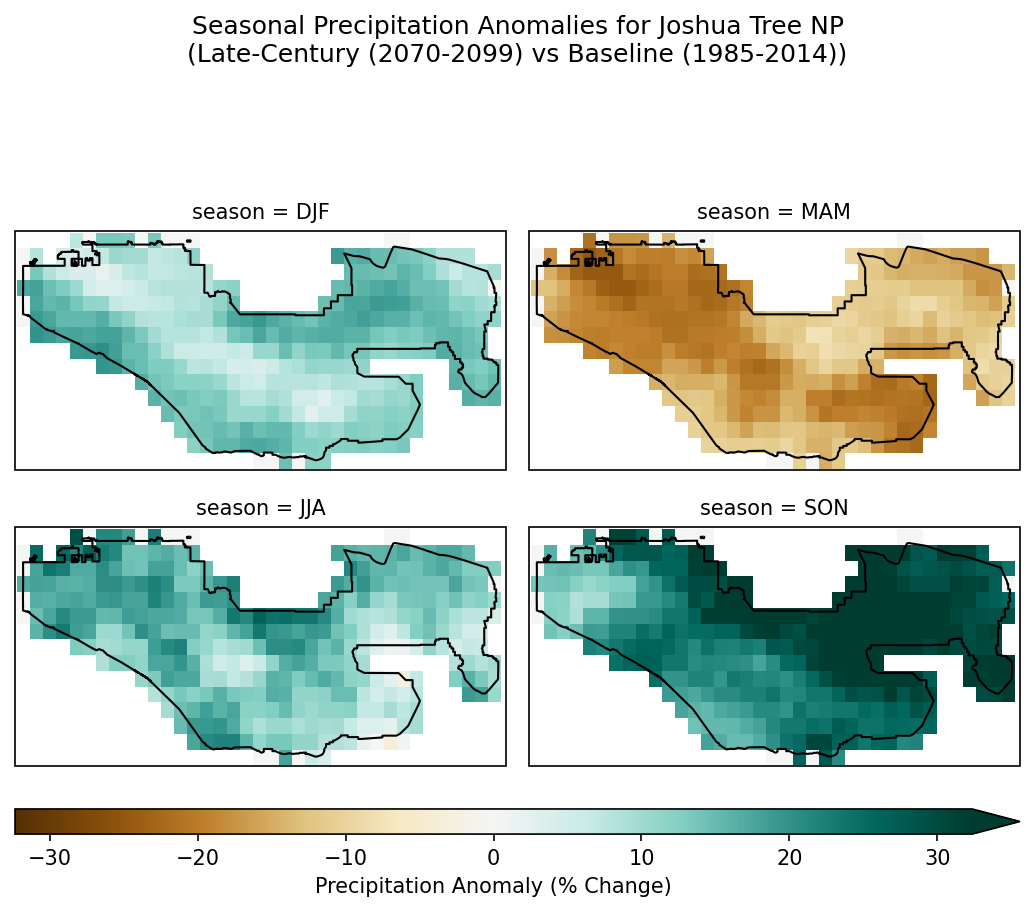

In [ ]:
if ccrs and 'precip_seasonal' in clipped_anomalies and clipped_anomalies['precip_seasonal'] is not None:
    dataToPlot = clipped_anomalies['precip_seasonal']
    #define projecting since data is reprojected to WGS84 , PlateCarree easy to do so
    projection = ccrs.PlateCarree()
    #here's this Dask array trouble again,
    #snure computation happens before calculating percentiles if data still a Dask array
    if hasattr(dataToPlot.data, 'dask'):
        dataToPlot.load()
        
    #get the fifth and 95th percentiles ignoring extreme outliers
        #maybe Lucia and Maya want outliers in, -> i'd remove them but idk if this is standard?
    vmin, vmax = np.nanpercentile(dataToPlot, [5, 95])
    #snrue scale is centered about 0 by using the max absolute value
    v_limit = max(abs(vmin), abs(vmax))
    
    #oh whoops, seasons should be ordered chronologically i suppose
    if 'season' in dataToPlot.dims:
        #safe select
        abalibelSeasons =dataToPlot.season.values
        ordreedSeasons = [s for s in ['DJF', 'MAM', 'JJA', 'SON'] if s in abalibelSeasons]
        dataToPlot = dataToPlot.sel(season=ordreedSeasons)
    else:
        print("season dimen not found, plotting sturcutre probably has a problem in it!")


    #need the faceted plot (2x2 grid based on 'season' dimen)
    #xarray/rioxarray automatically identify the spatial coords x/y after reporjection
    g = dataToPlot.plot(
        col='season', col_wrap=2, cmap='BrBG', center=0,
        vmin=-v_limit, vmax=v_limit, # Set symmetric color limits
        transform=projection,
        add_colorbar=True,
        cbar_kwargs={ 'label': f"Precipitation Anomaly ({dataToPlot.attrs.get('units', '%')})",'orientation': 'horizontal',
            'pad': 0.05, 'aspect': 40 },
        subplot_kws={'projection': projection}
    )
    #small paramters to customize maps and make them look better
    buffer = 0.02
    try:
        plot_extent = [longitude_slice[0]-buffer, longitude_slice[1]+buffer, 
                       latitude_slice[0]-buffer, latitude_slice[1]+buffer]

        for ax in g.axes.flat:
            if jTreeBoundary is not None:
                jTreeBoundary.boundary.plot(ax=ax, color='black', linewidth=1)            
            ax.set_extent(plot_extent, crs=projection)
        g.fig.suptitle(f'Seasonal Precipitation Anomalies for Joshua Tree NP\n({FUTURE_PERIOD["name"]} vs {BASELINE_PERIOD["name"]})', y=1.05)

    except NameError as e:
        print(f"run cell 2 ahgain.")

    plt.show()
else:
    print("missing libs needed for prep plto")

/tmp/ipykernel_677/4168556643.py:36: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in g.axes.flat:


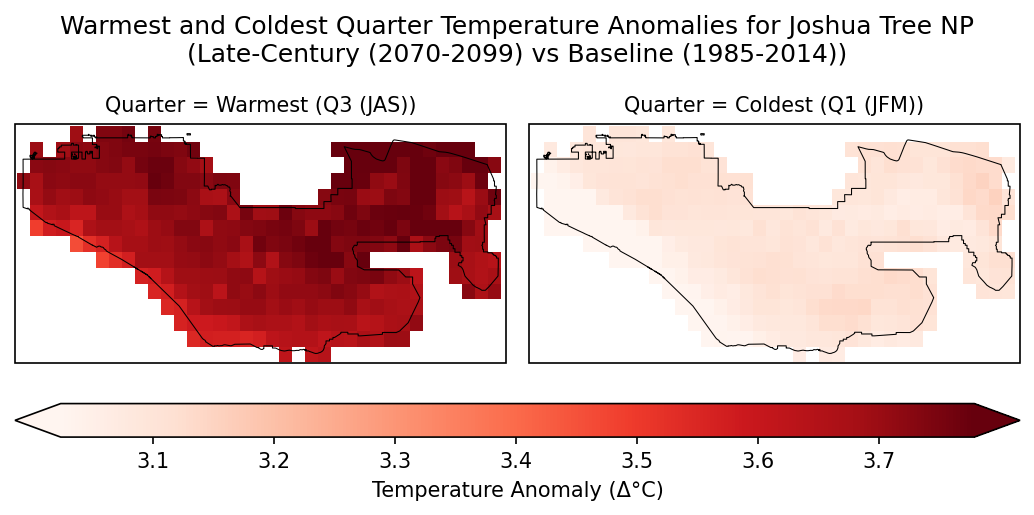

In [ ]:
#check if required data and indices warmestQIdx are available
if ccrs and 'temp_warmest_q' in clipped_anomalies and clipped_anomalies['temp_warmest_q'] is not None and 'WARMEST_Q_IDX' in globals():
    #need quarter names for ampping 
    qNeames = {1: "Q1 (JFM)", 2: "Q2 (AMJ)", 3: "Q3 (JAS)", 4: "Q4 (OND)"}
    #get warmest and coldest q data into single dArray for faceting
    mostWarmName =f"Warmest ({qNeames.get(WARMEST_Q_IDX)})"
    coldestName =f"Coldest ({qNeames.get(COLDEST_Q_IDX)})"
    mostWarm =clipped_anomalies['temp_warmest_q'].assign_coords(Quarter=mostWarmName)
    coldest =clipped_anomalies['temp_coldest_q'].assign_coords(Quarter=coldestName)
     #combine along a new dimen named quarter
    dataToPlot = xr.concat([mostWarm, coldest], dim='Quarter')
    projection = ccrs.PlateCarree()
    #colouring and also fix Dask array problem before it happens
    if hasattr(dataToPlot.data, 'dask'):
        dataToPlot.load()
    vmin,vmax = np.nanpercentile(dataToPlot, [5, 95])
    
    # Create the faceted plot (1x2 grid)
    #`1x2` grid faceted plot 
    g = dataToPlot.plot(
        col='Quarter', col_wrap=2, cmap='Reds', 
        vmin=vmin, vmax=vmax,
        transform=projection,
        add_colorbar=True,
        cbar_kwargs={ 'label': f"Temperature Anomaly ({dataToPlot.attrs.get('units', 'ΔC')})",
            'orientation': 'horizontal','pad': 0.1,'aspect': 30 },
        subplot_kws={'projection': projection}
    )

    #teeny params for better amps like before
    buffer = 0.02
    try:
        plot_extent = [longitude_slice[0]-buffer, longitude_slice[1]+buffer, 
                       latitude_slice[0]-buffer, latitude_slice[1]+buffer]

        for ax in g.axes.flat:
            if jTreeBoundary is not None:
                jTreeBoundary.boundary.plot(ax=ax, color='black', linewidth=0.5)
            ax.set_extent(plot_extent, crs=projection)
        g.fig.suptitle(f'Warmest and Coldest Quarter Temperature Anomalies for Joshua Tree NP\n({FUTURE_PERIOD["name"]} vs {BASELINE_PERIOD["name"]})', y=1.05)
    
    except NameError as e:
         print(f"run cell 2 ahgain.")

    plt.show()
else:
    print("missing libs needed for prep plto")

In [ ]:
#get annual climatologies and anomolies
print("\n--- Calculating Annual Climatologies (for 2x2 visualization) ---")

def calculate_annual_climatology_only(dataArray, startyear, endYear, varType):
    periodData = dataArray.sel(time=slice(str(startyear), str(endYear)))
    current_scenarios = list(np.atleast_1d(periodData.scenario.to_numpy()))
    #same as before
    if startyear < 2015:
        if "Historical Climate" in current_scenarios:
             scenario_to_select = "Historical Climate"
        elif len(current_scenarios) >0:
             scenario_to_select = current_scenarios[0]
        else:
            return None
        if 'scenario' in periodData.dims:
            periodData = periodData.sel(scenario=scenario_to_select, drop=True)
        else:
             periodData = periodData.drop_vars('scenario', errors='ignore')
    else:
        if 'scenario' not in periodData.dims and len(current_scenarios) > 0:
             periodData = periodData.expand_dims(dim={'scenario': current_scenarios})

    if varType == 'precip':
        annual_data = periodData.resample(time='YE').sum(dim='time')
        annual_climatology = annual_data.mean(dim='time')
        annual_climatology.attrs['units'] = 'mm/year'
    else:
        annual_data = periodData.resample(time='YE').mean(dim='time')
        annual_climatology = annual_data.mean(dim='time')
        annual_climatology.attrs['units'] = dataArray.attrs.get('units', '°C')
        
    return annual_climatology
for key, data in data_dict.items():
    if data is not None:
        print(f"Processing annual {key}...")
        baseline_a = calculate_annual_climatology_only(
            data, BASELINE_PERIOD["years"][0], BASELINE_PERIOD["years"][1], key)
        future_a = calculate_annual_climatology_only(
            data, FUTURE_PERIOD["years"][0], FUTURE_PERIOD["years"][1], key)
        
        if key not in climatologies:
            climatologies[key] = {}
        climatologies[key]["baseline_annual"] = baseline_a
        climatologies[key]["future_annual"] = future_a
if 'temp' in climatologies:
     anomalies_dict['temp_annual'] = calculate_anomalies(
         climatologies['temp'].get('baseline_annual'),
         climatologies['temp'].get('future_annual'),
         'temp'
     )

if 'precip' in climatologies:
     anomalies_dict['precip_annual'] = calculate_anomalies(
         climatologies['precip'].get('baseline_annual'),
         climatologies['precip'].get('future_annual'),
         'precip'
     )
print("Annual calculations complete.")


--- Calculating Annual Climatologies (for 2x2 visualization) ---
Processing annual temp...
Processing annual precip...
Annual calculations complete.


In [ ]:
print("\n--- Reprojecting and Clipping Annual Data ---")
baselineAnnualClipped = {}
if jTreeBoundary is not None:
    #process Annual Anomalies updating clipped_anomalies dictionary)
    #iterate over the keys just added to anomalies_dict
    for key in ['temp_annual', 'precip_annual']:
        if key in anomalies_dict and anomalies_dict.get(key) is not None:
            print(f"Processing on anomaly: {key}...")
            data = anomalies_dict[key]
            #squeeze scnario dimen (drop=True makes sure the scalar coodinate is also removed)
            data_squeezed = data.squeeze(drop=True)
            #existing reporject_and_clip function defined in notebook
            clipped_anomalies[key] = reproject_and_clip(data_squeezed, jTreeBoundary)
    #process baseline annual data
    for key in ['temp', 'precip']:
        #check if the baseline annual data exists in the climatoglogies dict
        if key in climatologies and climatologies[key].get('baseline_annual') is not None:
            print(f"Processing baseline annual: {key}...")
            #ensemble mean for baseline data
            baseline_data = climatologies[key]['baseline_annual'].mean(dim='simulation')
            #units must be preserved
            baseline_data.attrs['units'] =climatologies[key]['baseline_annual'].attrs.get('units')

            #clip baseline data
            baselineAnnualClipped[key] = reproject_and_clip(baseline_data, jTreeBoundary)

else:
    print("skipping clipping since boundary file didn't load")


--- Reprojecting and Clipping Annual Data ---
Processing anomaly: temp_annual...
Processing anomaly: precip_annual...
Processing baseline annual: temp...
Processing baseline annual: precip...
Clipping complete.



--- Generating 2x2 Baseline vs. Anomaly Visualization (Discrete Scale) ---


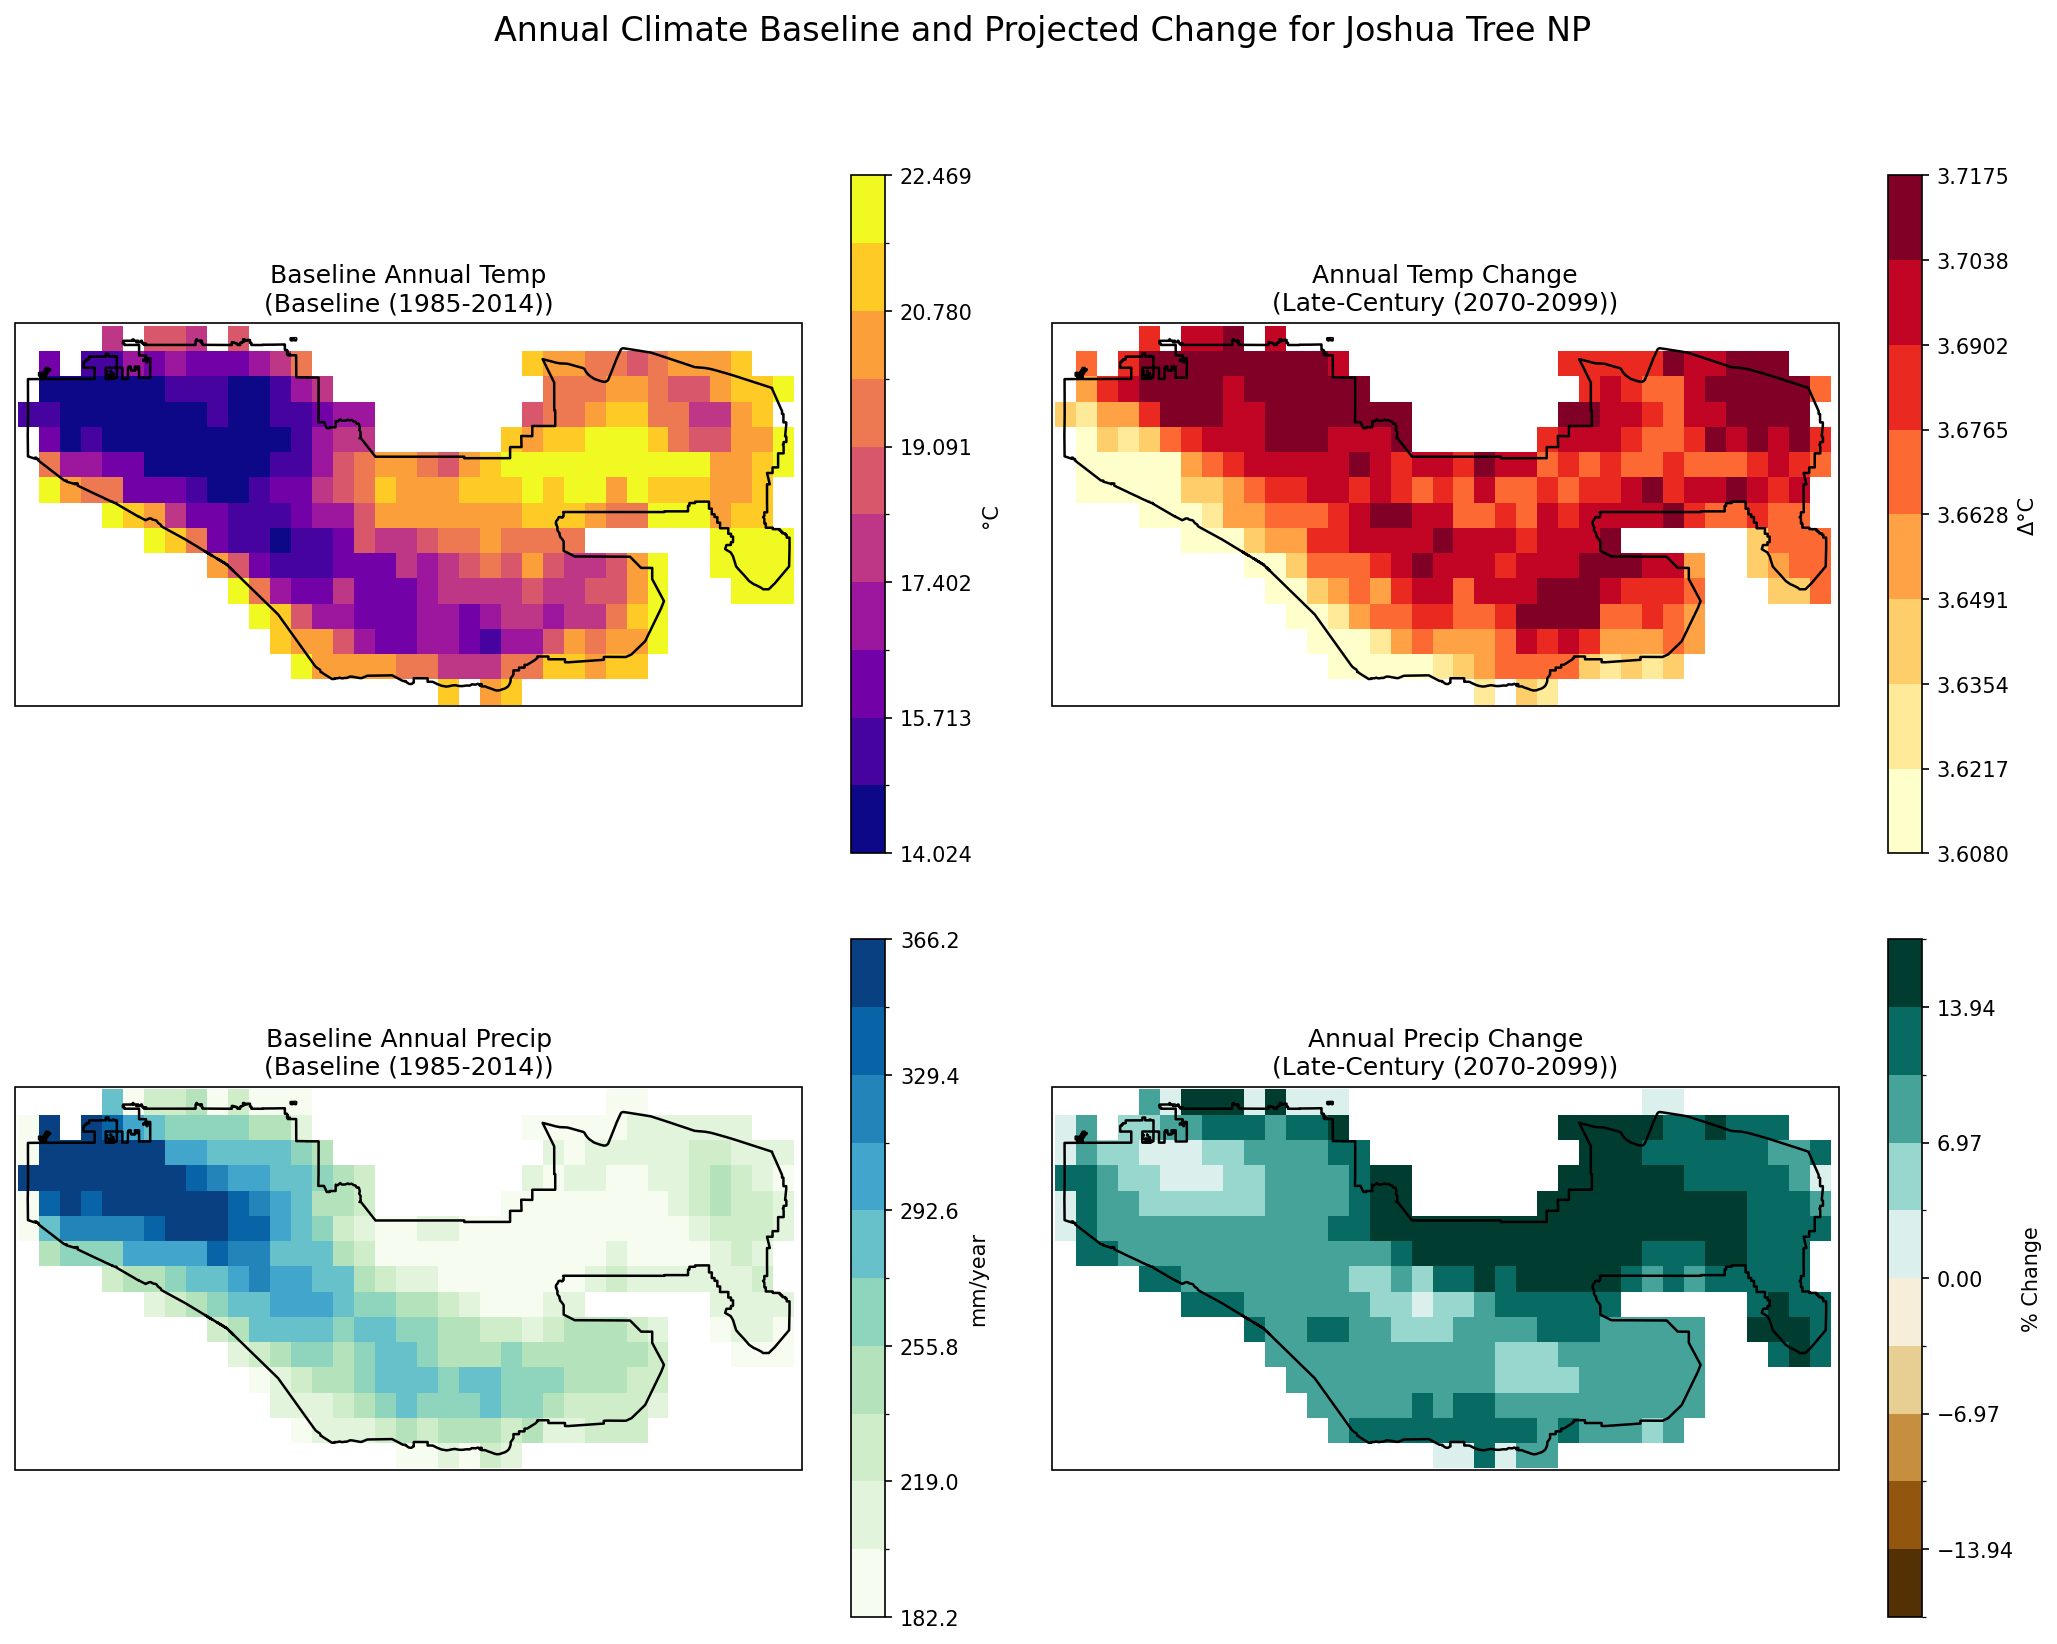

In [ ]:
#new Cell C generate 2x2 baseline vs anomaly vizualise (Discrete scale)
#imports needy for discrete colour scales
from matplotlib.colors import BoundaryNorm
import matplotlib.cm as cm #colour mapping 
#safe for cartopy installed and dicts populated
if ccrs and baselineAnnualClipped and clipped_anomalies:
    if all(key in baselineAnnualClipped and baselineAnnualClipped.get(key) is not None for key in ['temp', 'precip']) and \
       all(key in clipped_anomalies and clipped_anomalies.get(key) is not None for key in ['temp_annual', 'precip_annual']):
        
        #2x2 plotsetup
        projection =ccrs.PlateCarree()
        #adjust figsize for a godo asepct ratio
        fig,axes= plt.subplots(2, 2, figsize=(14, 12), subplot_kw={'projection': projection})
        #plot extent 
        buffer =0.02
        try:
            plot_extent =[longitude_slice[0]-buffer, longitude_slice[1]+buffer,latitude_slice[0]-buffer,latitude_slice[1]+buffer]
        except NameError:
            plot_extent =None
        def plot_discrete_panel(ax, data, cmap_name, title, num_bins=8, center=None):
            # Ensure data is computed if it's a Dask array
            #dask cehck like above
            if hasattr(data.data, 'dask'):
                data.load()
            #also check about this w/ M + L //TODO
            vmin, vmax = np.nanpercentile(data, [5, 95])
            #determine bisn for discrete scale
            if center is not None:
                #diverging map centereted @ 0
                vlim = max(abs(vmin),abs(vmax))
                #ensure an even number of bins for symmetry around the center
                n_bins = num_bins if num_bins %2==0 else num_bins + 1
                levels =np.linspace(-vlim, vlim, n_bins + 1)
            else:
                levels = np.linspace(vmin, vmax, num_bins + 1)
            #create the colourmap and normalisation (boundaryNom discretzes the colour)
            try:
                #plt.colourmaps and resample from numebr of bisn
                cmap= plt.colormaps[cmap_name].resampled(len(levels) - 1)
            except (KeyError, AttributeError):
                print(f" Issue w/ colormap '{cmap_name}'gonna use fallback")
                #use plt.get_cmap for fall back
                cmap = plt.get_cmap(cmap_name, len(levels) -1)
            norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
            mesh = data.plot.pcolormesh(
                ax=ax,transform=projection,cmap=cmap,norm=norm,add_colorbar=False)
            if plot_extent:
                ax.set_extent(plot_extent, crs=projection)   
            if jTreeBoundary is not None:
                #use a slightly thicker boundary for visual clarity
                jTreeBoundary.boundary.plot(ax=ax, color='black', linewidth=1.2)
            ax.set_title(title)
            return mesh
        #plotting the panels; row1 temp; plasma for abs temperature 
        mesh_temp_base = plot_discrete_panel(axes[0, 0], baselineAnnualClipped['temp'], 
                                             'plasma', 
                                             f"Baseline Annual Temp\n({BASELINE_PERIOD['name']})", num_bins=10)
        #'YlOrRd' for temp change anomoly

        mesh_temp_anom = plot_discrete_panel(axes[0, 1], 
                                             clipped_anomalies['temp_annual'], 'YlOrRd', 
                                             f"Annual Temp Change\n({FUTURE_PERIOD['name']})", 
                                             num_bins=8)
        #preip
        mesh_precip_base = plot_discrete_panel(axes[1, 0], baselineAnnualClipped['precip'], 'GnBu', 
                                               f"Baseline Annual Precip\n({BASELINE_PERIOD['name']})", num_bins=10)
        #use BrBG which is diverging 
        mesh_precip_anom = plot_discrete_panel(axes[1, 1], clipped_anomalies['precip_annual'], 'BrBG', 
                                               f"Annual Precip Change\n({FUTURE_PERIOD['name']})", 
                                               num_bins=10, 
                                               center=0)
        #colourbars (discrete)
        #Δ (delta here)
        fig.colorbar(mesh_temp_base, ax=axes[0, 0], orientation='vertical', shrink=0.8,label=baselineAnnualClipped['temp'].attrs.get('units', '°C'))
        fig.colorbar(mesh_temp_anom, ax=axes[0, 1], orientation='vertical', shrink=0.8,label=clipped_anomalies['temp_annual'].attrs.get('units', 'Δ°C')) 
        fig.colorbar(mesh_precip_base, ax=axes[1, 0],orientation='vertical', shrink=0.8, label=baselineAnnualClipped['precip'].attrs.get('units', 'mm/year'))
        fig.colorbar(mesh_precip_anom, ax=axes[1, 1], orientation='vertical', shrink=0.8, label=clipped_anomalies['precip_annual'].attrs.get('units', '% Change'))

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])#prevent titles overlappign ugh
        fig.suptitle('Annual Climate Baseline and Projected Change for Joshua Tree NP', fontsize=16)
        plt.show()

    else:
        print("Missing some req data components")
else:
    print("skippinhg 2x2 vis, lib problem check cell 1")